In [1]:
# ======= Install packages =======
!pip install -q transformers datasets huggingface_hub accelerate torchvision ftfy regex tqdm


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.8/44.8 kB 3.6 MB/s eta 0:00:00


In [2]:
# ======= Imports =======
import os
import math
import random
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset

from datasets import load_dataset

from torchvision import models, transforms
from transformers import AutoTokenizer, CLIPProcessor, CLIPModel

In [3]:

# ======= Configuration / Hyperparams =======
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)

K = 3                        # sequence length (use first K frames)
IMG_SIZE = 224
BATCH_SIZE = 4               # small for Colab debugging; increase with GPU
SUBSET_SIZE = 400            # how many stories to use (for quick runs)
EPOCHS = 1                  # small for debug; increase later
LR = 1e-4
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

os.makedirs("results/samples_seq", exist_ok=True)
os.makedirs("checkpoints_seq", exist_ok=True)
os.makedirs("results/plots", exist_ok=True)

print("Device:", DEVICE)


Device: cuda


In [4]:
# ======= Load dataset =======
ds = load_dataset("daniel3303/StoryReasoning")
print(ds)

# We'll work with the 'train' split. If dataset is small, ok to use both.
raw = ds["train"]

# ======= Utilities: sentence-split (simple) and safe image loader =======
def naive_sent_split(text):
    # Very simple split by period, question mark, exclamation; strip empties
    if text is None:
        return []
    s = []
    for part in text.replace("?", ".").replace("!", ".").split("."):
        p = part.strip()
        if len(p) > 3:
            s.append(p)
    return s

from torchvision.transforms import functional as TF
image_tf = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor()
])

def pil_to_tensor(img):
    return image_tf(img.convert("RGB"))

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md: 0.00B [00:00, ?B/s]

data/train-00000-of-00002.parquet:   0%|          | 0.00/327M [00:00<?, ?B/s]

data/train-00001-of-00002.parquet:   0%|          | 0.00/331M [00:00<?, ?B/s]

data/test-00000-of-00001.parquet:   0%|          | 0.00/115M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/3552 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/626 [00:00<?, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['story_id', 'images', 'frame_count', 'chain_of_thought', 'story'],
        num_rows: 3552
    })
    test: Dataset({
        features: ['story_id', 'images', 'frame_count', 'chain_of_thought', 'story'],
        num_rows: 626
    })
})


In [5]:
# ======= Build a PyTorch Dataset for seq->next image =======
class StorySeqDataset(Dataset):
    def __init__(self, hf_dataset, tokenizer, K=3, limit=None):
        self.items = []
        self.K = K
        self.tokenizer = tokenizer

        # iterate and form (K image tensors, K text tensors) -> target image
        count = 0
        for ex in tqdm(hf_dataset):
            # require at least K+1 frames
            imgs = ex.get("images", None)
            if not imgs or len(imgs) < (K + 1):
                continue

            # get story text -> split into sentences
            story_text = ex.get("story", "") or ex.get("chain_of_thought", "") or ""
            sents = naive_sent_split(story_text)

            # if not enough sentences, fall back to equally splitting sentences across frames
            if len(sents) < (len(imgs)):
                # try to use each image's v1 alt text in some datasets; here we fallback
                # to duplicate the whole story into each timestep
                sents = [story_text]*len(imgs)

            # choose a contiguous subsequence of length K+1 if available
            max_start = len(imgs) - (K + 1)
            if max_start < 0:
                continue
            start = 0  # fixed alignment: use beginning of story
            # optional: randomize start for augmentation
            # start = random.randint(0, max_start)

            try:
                # load tensors for K inputs and target
                input_imgs = []
                input_texts = []
                for i in range(start, start + K):
                    pil = imgs[i]
                    if isinstance(pil, str):
                        # in some HF datasets, images may be URL strings; skip those examples
                        raise Exception("image is path/str")
                    input_imgs.append(pil_to_tensor(pil))
                    # text for this frame: pick sentence i if available else whole story
                    text_sent = sents[i] if i < len(sents) else story_text
                    input_texts.append(text_sent)

                # target image
                target_img = pil_to_tensor(imgs[start + K])
            except Exception:
                # skip bad examples (URL-only images, etc.)
                continue

            # store
            self.items.append({
                "imgs": torch.stack(input_imgs),   # shape (K,3,H,W)
                "texts": input_texts,              # list[str] length K
                "target": target_img
            })

            count += 1
            if limit and count >= limit:
                break

        print(f"Prepared {len(self.items)} sequence examples (K={K}).")

    def __len__(self):
        return len(self.items)

    def __getitem__(self, idx):
        it = self.items[idx]
        return it

In [6]:

# ======= Tokenizer and CLIP for evaluation =======
tokenizer = AutoTokenizer.from_pretrained("bert-base-uncased")
# CLIP for evaluation of text-image alignment:
clip_model = CLIPModel.from_pretrained("openai/clip-vit-base-patch32").to(DEVICE)
clip_processor = CLIPProcessor.from_pretrained("openai/clip-vit-base-patch32")

# ======= Build dataset instance (subset for speed) =======
dataset_seq = StorySeqDataset(raw, tokenizer, K=K, limit=SUBSET_SIZE)
print("Dataset examples:", len(dataset_seq))

# ======= Collate fn to batch variable-length text per timestep =======
def collate_fn(batch):
    # batch is list of dicts with 'imgs' (K,3,H,W), 'texts' list[K], 'target' (3,H,W)
    K_local = batch[0]["imgs"].shape[0]
    imgs = torch.stack([b["imgs"] for b in batch])        # (B, K, 3, H, W)
    targets = torch.stack([b["target"] for b in batch])   # (B, 3, H, W)

    # For texts: we will tokenize each timestep separately and pad to fixed max_len
    # Flatten texts to (B*K) then reshape
    texts_flat = [t for b in batch for t in b["texts"]]
    tokenized = tokenizer(texts_flat, padding="max_length", truncation=True, max_length=32, return_tensors="pt")
    # reshape to (B, K, seq_len)
    seq_len = tokenized["input_ids"].shape[1]
    input_ids = tokenized["input_ids"].view(len(batch), K_local, seq_len)
    attention_mask = tokenized["attention_mask"].view(len(batch), K_local, seq_len)

    return {
        "imgs": imgs,               # (B, K, 3, H, W)
        "input_ids": input_ids,     # (B, K, seq_len)
        "attention_mask": attention_mask,
        "targets": targets          # (B, 3, H, W)
    }

train_loader = DataLoader(dataset_seq, batch_size=BATCH_SIZE, shuffle=True, collate_fn=collate_fn)

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json: 0.00B [00:00, ?B/s]

pytorch_model.bin:   0%|          | 0.00/605M [00:00<?, ?B/s]

Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.


preprocessor_config.json:   0%|          | 0.00/316 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/605M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/592 [00:00<?, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

merges.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/389 [00:00<?, ?B/s]


 11%|█         | 399/3552 [00:07<01:01, 51.26it/s]

Prepared 400 sequence examples (K=3).
Dataset examples: 400


In [31]:
# ======= Hyperparameters & Device =======
LR = 2e-4
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
print("Using device:", DEVICE)

# ======= Model components =======

import torch
import torch.nn as nn
from torchvision import models
from transformers import CLIPProcessor, CLIPModel

class VisualEncoder(nn.Module):
    def __init__(self, out_dim=512):
        super().__init__()
        resnet = models.resnet50(weights=models.ResNet50_Weights.IMAGENET1K_V1)
        self.backbone = nn.Sequential(*list(resnet.children())[:-1])
        self.fc = nn.Linear(2048, out_dim)

    def forward(self, x):
        feat = self.backbone(x).flatten(1)
        return self.fc(feat)

class TextEncoder(nn.Module):
    def __init__(self, vocab_size, embed_dim=256, hidden_dim=512):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, embed_dim)
        self.lstm = nn.LSTM(embed_dim, hidden_dim, batch_first=True)

    def forward(self, input_ids, attention_mask=None):
        emb = self.embedding(input_ids)
        _, (h, _) = self.lstm(emb)
        return h.squeeze(0)

class FusionPerTimestep(nn.Module):
    def __init__(self, img_dim=512, txt_dim=512, fused_dim=512):
        super().__init__()
        self.fc = nn.Linear(img_dim + txt_dim, fused_dim)
        self.act = nn.ReLU()

    def forward(self, img_feat, txt_feat):
        return self.act(self.fc(torch.cat([img_feat, txt_feat], dim=1)))

class SeqModelGRU(nn.Module):
    def __init__(self, input_dim=512, hidden_dim=512):
        super().__init__()
        self.gru = nn.GRU(input_dim, hidden_dim, batch_first=True)

    def forward(self, seq_feats):
        out, h = self.gru(seq_feats)
        return out, h[-1]

class Generator(nn.Module):
    def __init__(self, in_dim):
        super().__init__()
        self.fc = nn.Linear(in_dim, 512 * 4 * 4)
        self.up = nn.Sequential(
            nn.ConvTranspose2d(512, 256, 4, 2, 1),
            nn.ReLU(True),
            nn.ConvTranspose2d(256, 128, 4, 2, 1),
            nn.ReLU(True),
            nn.ConvTranspose2d(128, 3, 4, 2, 1),
            nn.Sigmoid()
        )

    def forward(self, z):
        x = self.fc(z)
        x = x.view(z.size(0), 512, 4, 4)
        x = self.up(x)
        return x

class Discriminator(nn.Module):
    def __init__(self):
        super().__init__()
        self.model = nn.Sequential(
            nn.Conv2d(3, 64, 4, 2, 1),
            nn.LeakyReLU(0.2),
            nn.Conv2d(64, 128, 4, 2, 1),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2),
            nn.Conv2d(128, 256, 4, 2, 1),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.2),
            nn.Conv2d(256, 512, 4, 2, 1),
            nn.BatchNorm2d(512),
            nn.LeakyReLU(0.2),
            nn.Conv2d(512, 1, 4, 2, 1)
        )

    def forward(self, x):
        out = self.model(x)
        return out.view(out.size(0), -1)

# ======= Instantiate models =======
IN_DIM = 512  # latent dimension from GRU/TextEncoder
G = Generator(in_dim=IN_DIM).to(DEVICE)
D = Discriminator().to(DEVICE)

# ======= Load CLIP =======
clip_model = CLIPModel.from_pretrained("openai/clip-vit-base-patch32").to(DEVICE)
clip_processor = CLIPProcessor.from_pretrained("openai/clip-vit-base-patch32")

# ======= Optimizers =======
g_opt = torch.optim.Adam(G.parameters(), lr=LR, betas=(0.5, 0.999))
d_opt = torch.optim.Adam(D.parameters(), lr=LR, betas=(0.5, 0.999))

# ======= Loss functions =======
adversarial_loss = nn.BCEWithLogitsLoss()
recon_loss = nn.L1Loss()

print("Model setup complete")


Using device: cuda
Model setup complete


In [33]:
# ======= Full Multimodal Model (wraps modules) =======
class StorySeqGAN(nn.Module):
    def __init__(self, vocab_size, img_feat_dim=512, txt_hidden=512, fused_dim=512, seq_hidden=512):
        super().__init__()
        self.visual_enc = VisualEncoder(out_dim=img_feat_dim)
        self.text_enc = TextEncoder(vocab_size=vocab_size, embed_dim=256, hidden_dim=txt_hidden)
        self.fusion = FusionPerTimestep(img_dim=img_feat_dim, txt_dim=txt_hidden, fused_dim=fused_dim)
        self.seq_model = SeqModelGRU(input_dim=fused_dim, hidden_dim=seq_hidden)


        self.gen = Generator(in_dim=seq_hidden)

    def forward(self, imgs_seq, input_ids_seq, attention_mask_seq):
        B, K, C, H, W = imgs_seq.shape
        imgs_seq = imgs_seq.view(B*K, C, H, W)
        img_feats = self.visual_enc(imgs_seq)
        img_feats = img_feats.view(B, K, -1)

        B, K, seq_len = input_ids_seq.shape
        input_ids_flat = input_ids_seq.view(B*K, seq_len).to(DEVICE)
        att_flat = attention_mask_seq.view(B*K, seq_len).to(DEVICE)

        txt_feats = self.text_enc(input_ids_flat, att_flat)
        txt_feats = txt_feats.view(B, K, -1)

        fused = []
        for t in range(K):
            fused_t = self.fusion(img_feats[:, t, :], txt_feats[:, t, :])
            fused.append(fused_t.unsqueeze(1))
        fused_seq = torch.cat(fused, dim=1)

        out_seq, last_h = self.seq_model(fused_seq)
        gen_img = self.gen(last_h)
        return gen_img

# ======= Instantiate =======
vocab_size = tokenizer.vocab_size
G = StorySeqGAN(vocab_size=vocab_size).to(DEVICE)
D = Discriminator().to(DEVICE)

g_opt = torch.optim.Adam(G.parameters(), lr=LR, betas=(0.5, 0.999))
d_opt = torch.optim.Adam(D.parameters(), lr=LR, betas=(0.5, 0.999))

adversarial_loss = nn.BCEWithLogitsLoss()
recon_loss = nn.L1Loss()


In [34]:
g_losses, d_losses, clip_scores = [], [], []
global_step = 0

for epoch in range(EPOCHS):
    G.train(); D.train()
    pbar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{EPOCHS}")
    for batch in pbar:
        imgs = batch["imgs"].to(DEVICE)              # (B, K, 3, H, W)
        input_ids = batch["input_ids"].to(DEVICE)    # (B, K, seq_len)
        att_mask = batch["attention_mask"].to(DEVICE)
        targets = batch["targets"].to(DEVICE)        # (B,3,H,W)
        B = imgs.shape[0]

        # ===== Discriminator step =====
        d_opt.zero_grad()
        with torch.no_grad():
            fake_imgs = G(imgs, input_ids, att_mask)   # (B,3,H,W)

        real_preds = D(targets)                        # (B, n_patches)
        fake_preds = D(fake_imgs.detach())             # (B, n_patches)

        real_labels = torch.ones_like(real_preds, device=DEVICE)
        fake_labels = torch.zeros_like(fake_preds, device=DEVICE)

        d_loss_real = adversarial_loss(real_preds, real_labels)
        d_loss_fake = adversarial_loss(fake_preds, fake_labels)
        d_loss = 0.5 * (d_loss_real + d_loss_fake)
        d_loss.backward()
        d_opt.step()

        # ===== Generator step =====
        g_opt.zero_grad()
        gen_imgs = G(imgs, input_ids, att_mask)        # (B,3,H,W)
        pred_logits = D(gen_imgs)                      # (B, n_patches)

        # Generator losses
        g_adv = adversarial_loss(pred_logits, real_labels)   # adversarial (want real)
        g_l1  = recon_loss(gen_imgs, targets)                # pixel alignment
        g_loss = 1.0 * g_adv + 10.0 * g_l1

        g_loss.backward()
        g_opt.step()

        # ===== Logging & CLIP evaluation every N steps =====
        if global_step % 10 == 0:
            G.eval()
            with torch.no_grad():
                # clamp and CPU numpy for saving/visualization
                gen_imgs_eval = gen_imgs.clamp(0,1).cpu().numpy()
                targets_cpu = targets.clamp(0,1).cpu().numpy()

                # Build natural-language prompts for CLIP:
                # We will create a short prompt per example by concatenating the K input texts (but let CLIP tokenizer truncate)
                texts_for_clip = []
                # Note: input_ids has shape (B, K, seq_len) using BERT tokenizer indices.
                # Convert each (K, seq_len) group to plain text via tokenizer.decode, but to be safe, limit characters
                for bidx in range(B):
                    # decode each timestep's token ids (use the BERT tokenizer you loaded)
                    # then join them; clip tokenizer will truncate to 77 tokens.
                    parts = []
                    for k in range(input_ids.size(1)):
                        ids = input_ids[bidx, k].cpu().numpy()
                        # remove padding ids
                        ids = ids[ids != tokenizer.pad_token_id]
                        if ids.size:
                            try:
                                txt = tokenizer.decode(ids, skip_special_tokens=True)
                            except Exception:
                                txt = ""
                        else:
                            txt = ""
                        parts.append(txt)
                    prompt = " ".join([p for p in parts if len(p.strip())>0])
                    # Safety: limit prompt length (characters) to avoid extreme inputs
                    if len(prompt) > 500:
                        prompt = prompt[:500]
                    texts_for_clip.append(prompt if len(prompt)>0 else "a scene described in the story")

                # Prepare CLIP inputs safely: tokenize text (truncate to CLIP max length 77)
                tokenized_clip_text = clip_processor.tokenizer(
                    texts_for_clip,
                    padding=True,
                    truncation=True,
                    max_length=77,
                    return_tensors="pt",
                ).to(DEVICE)

                # Prepare images using clip_processor to get pixel_values:
                pil_gen = [Image.fromarray((255*(gen_imgs_eval[i].transpose(1,2,0))).astype(np.uint8)) for i in range(B)]
                clip_imgs = clip_processor(images=pil_gen, return_tensors="pt")["pixel_values"].to(DEVICE)

                clip_inputs = {
                    "input_ids": tokenized_clip_text["input_ids"],
                    "attention_mask": tokenized_clip_text["attention_mask"],
                    "pixel_values": clip_imgs
                }

                # forward through CLIP
                clip_out = clip_model(**clip_inputs)
                text_emb = clip_out.text_embeds    # (B, D)
                img_emb  = clip_out.image_embeds   # (B, D)
                # cosine similarity
                text_emb = text_emb / text_emb.norm(p=2, dim=-1, keepdim=True)
                img_emb = img_emb / img_emb.norm(p=2, dim=-1, keepdim=True)
                sims = (text_emb * img_emb).sum(dim=-1).detach().cpu().numpy()  # (B,)
                avg_clip = float(sims.mean())

            # append metrics
            g_losses.append(float(g_loss.item()))
            d_losses.append(float(d_loss.item()))
            clip_scores.append(avg_clip)

            pbar.set_postfix({"g_loss":g_losses[-1], "d_loss":d_losses[-1], "clip":clip_scores[-1]})

            # save a sample grid (first item in batch): ground truth | generated
            grid_img = np.concatenate([
                targets_cpu[0].transpose(1,2,0),
                gen_imgs_eval[0].transpose(1,2,0)
            ], axis=1)
            grid_img = (grid_img * 255).astype(np.uint8)
            Image.fromarray(grid_img).save(f"results/samples_seq/epoch{epoch}_step{global_step}.png")

            G.train()

        global_step += 1

    # epoch checkpoint
    torch.save({
        "G": G.state_dict(),
        "D": D.state_dict(),
        "g_opt": g_opt.state_dict(),
        "d_opt": d_opt.state_dict()
    }, f"checkpoints_seq/epoch_{epoch}.pt")

# After loop: save final plots
import matplotlib.pyplot as plt
plt.figure(figsize=(8,4))
plt.plot(g_losses, label="G_loss")
plt.plot(d_losses, label="D_loss")
plt.legend()
plt.title("GAN Losses")
plt.savefig("results/plots/losses.png")
plt.close()

plt.figure(figsize=(6,4))
plt.plot(clip_scores, label="CLIP sim")
plt.legend()
plt.title("CLIP similarity progression")
plt.savefig("results/plots/clip.png")
plt.close()

print("Training complete. Samples and checkpoints saved.")

Epoch 1/1: 100%|██████████| 100/100 [00:25<00:00,  3.86it/s, g_loss=7.25, d_loss=0.0221, clip=0.251]


Training complete. Samples and checkpoints saved.


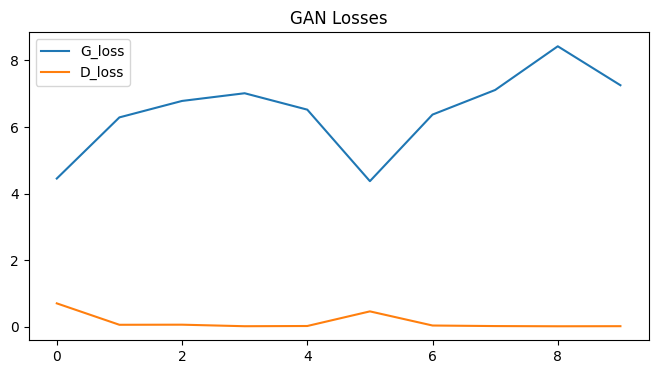

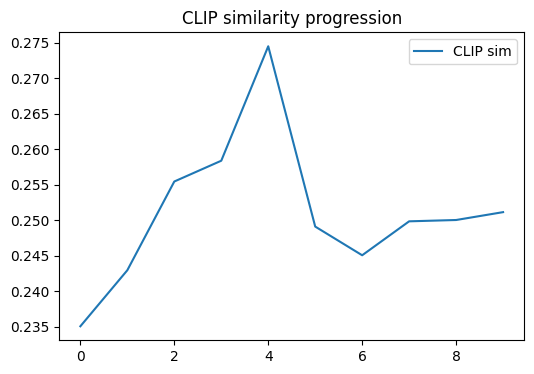

Done. Samples, checkpoints, and plots saved in results/ and checkpoints_seq/


In [39]:

# ======= After training: plots =======
plt.figure(figsize=(8,4))
plt.plot(g_losses, label="G_loss")
plt.plot(d_losses, label="D_loss")
plt.legend()
plt.title("GAN Losses")
plt.savefig("results/plots/losses.png")
plt.show()

plt.figure(figsize=(6,4))
plt.plot(clip_scores, label="CLIP sim")
plt.legend()
plt.title("CLIP similarity progression")
plt.savefig("results/plots/clip.png")
plt.show()

print("Done. Samples, checkpoints, and plots saved in results/ and checkpoints_seq/")
